<a href="https://colab.research.google.com/github/lszam/potentials-on/blob/main/PosDocON_Mag_EMAG2_2_SAmerica_Low_High_frequecies.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **1. Environment**

In [1]:
!pip install rasterio -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 18.5 MB/s eta 0:00:00


In [2]:
# 📥 Magnetic data --> EMAG2v3
# GeoTIFFs
!wget -O EMAG2v3_UpCont.tif https://www.ngdc.noaa.gov/geomag/data/EMAG2/EMAG2_V3_20170530/EMAG2_V3_20170530_UpCont.tif
!wget -O EMAG2v3_Sealevel.tif https://www.ngdc.noaa.gov/geomag/data/EMAG2/EMAG2_V3_20170530/EMAG2_V3_20170530_Sealevel.tif

--2025-06-22 16:37:02--  https://www.ngdc.noaa.gov/geomag/data/EMAG2/EMAG2_V3_20170530/EMAG2_V3_20170530_UpCont.tif
Resolving www.ngdc.noaa.gov (www.ngdc.noaa.gov)... 140.172.190.2, 140.172.190.1
Connecting to www.ngdc.noaa.gov (www.ngdc.noaa.gov)|140.172.190.2|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 239593097 (228M) [image/tiff]
Saving to: ‘EMAG2v3_UpCont.tif’

EMAG2v3_UpCont.tif  100%[===================>] 228.49M  9.20MB/s    in 26s     

2025-06-22 16:37:28 (8.90 MB/s) - ‘EMAG2v3_UpCont.tif’ saved [239593097/239593097]

--2025-06-22 16:37:28--  https://www.ngdc.noaa.gov/geomag/data/EMAG2/EMAG2_V3_20170530/EMAG2_V3_20170530_Sealevel.tif
Resolving www.ngdc.noaa.gov (www.ngdc.noaa.gov)... 140.172.190.2, 140.172.190.1
Connecting to www.ngdc.noaa.gov (www.ngdc.noaa.gov)|140.172.190.2|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 239593097 (228M) [image/tiff]
Saving to: ‘EMAG2v3_Sealevel.tif’

EMAG2v3_Sealevel.ti 100%[========

**Importar bibliotecas**

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import rasterio
from rasterio.transform import from_origin
from scipy.fftpack import fft2, ifft2, fftshift

# **2. Preparing mag data**

Read geotiff data

In [81]:
#with rasterio.open("EMAG2v3_UpCont.tif") as src:
with rasterio.open("EMAG2v3_Sealevel.tif") as src:
    data = src.read(1).astype(np.float32)
    data[data == -3.4028235e+38] = np.nan # 'no data' do float32
    transform = src.transform
    #dx, dy = src.res
    #width = src.width
    #height = src.height
    dx = transform.a
    dy = -abs(transform.e) #negativ sign recquired for the coord transform
    print("CRS:", src.crs)
    print("Transform:", src.transform)
    print("Bounds:", src.bounds)
    print("Width x Height:", src.width, "x", src.height)

print(f"dx: {dx}, dy: {dy}")

lon0, lat0 = transform * (0.5, 0.5)  # center of each pixel
lons = np.linspace(lon0, lon0 + dx * (n_cols - 1), n_cols)
lats = np.linspace(lat0, lat0 + dy * (n_rows - 1), n_rows)
print(f"lons.shape: {lons.shape}, lats.shape: {lats.shape}")
print(f"lons.min(): {lons.min()}, lons.max(): {lons.max()}")
print(f"lats.min(): {lats.min()}, lats.max(): {lats.max()}")

CRS: None
Transform: | 0.03, 0.00,-0.02|
| 0.00,-0.03, 89.98|
| 0.00, 0.00, 1.00|
Bounds: BoundingBox(left=-0.0166666666675, bottom=-89.9833333378325, right=359.9833333513325, top=89.9833333378325)
Width x Height: 10800 x 5399
dx: 0.033333333335, dy: -0.033333333335
lons.shape: (10800,), lats.shape: (5399,)
lons.min(): 0.0, lons.max(): 359.966666684665
lats.min(): -89.966666671165, lats.max(): 89.966666671165


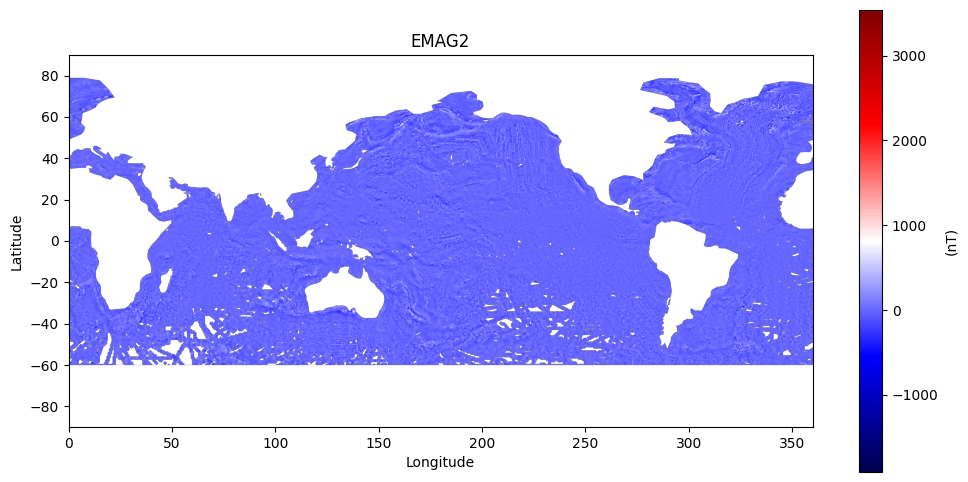

In [80]:
fig, ax = plt.subplots(figsize=(12, 6))
im = ax.imshow(
    data,
    extent=[lons.min(), lons.max(), lats.min(), lats.max()],
    origin='upper',
    cmap='seismic'
)
ax.set_title("EMAG2")
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
plt.colorbar(im, ax=ax, label="(nT)")

In [82]:
# Construir vetores de coordenadas corretamente
n_rows, n_cols = data.shape
dx = 0.033333333333  # resolução conhecida do EMAG2v3
dy = -0.033333333333
lon0 = -0.0166666666675
lat0 = 89.9833333378325
lons = np.linspace(lon0, lon0 + dx * (n_cols - 1), n_cols)
lats = np.linspace(lat0, lat0 + dy * (n_rows - 1), n_rows)
print(f"lons.shape: {lons.shape}, lats.shape: {lats.shape}")
print(f"lons.min(): {lons.min()}, lons.max(): {lons.max()}")
print(f"lats.min(): {lats.min()}, lats.max(): {lats.max()}")

lons.shape: (10800,), lats.shape: (5399,)
lons.min(): -0.0166666666675, lons.max(): 359.9499999963995
lats.min(): -89.94999999370151, lats.max(): 89.9833333378325


Changing from 0 - 360 to -180 - +180

In [93]:
lons = np.linspace(lon0, lon0 + dx * (n_cols - 1), n_cols)
lons = np.where(lons > 180, lons - 360, lons)
sorted_idx = np.argsort(lons)
lons = lons[sorted_idx]
data = data[:, sorted_idx]
# Cria um vetor com pontos igualmente espaçados (n_rows pontos)
# com valor final = lat0 + dy * (n_rows - 1)
lats = np.linspace(lat0, lat0 + dy * (n_rows - 1), n_rows)

print(f"lons.shape: {lons.shape}, lats.shape: {lats.shape}")
print(f"lons.min(): {lons.min()}, lons.max(): {lons.max()}")
print(f"lats.min(): {lats.min()}, lats.max(): {lats.max()}")

lons.shape: (10800,), lats.shape: (5399,)
lons.min(): -179.9833333351345, lons.max(): 179.98333333153252
lats.min(): -89.94999999370151, lats.max(): 89.9833333378325


✂️ Windowing

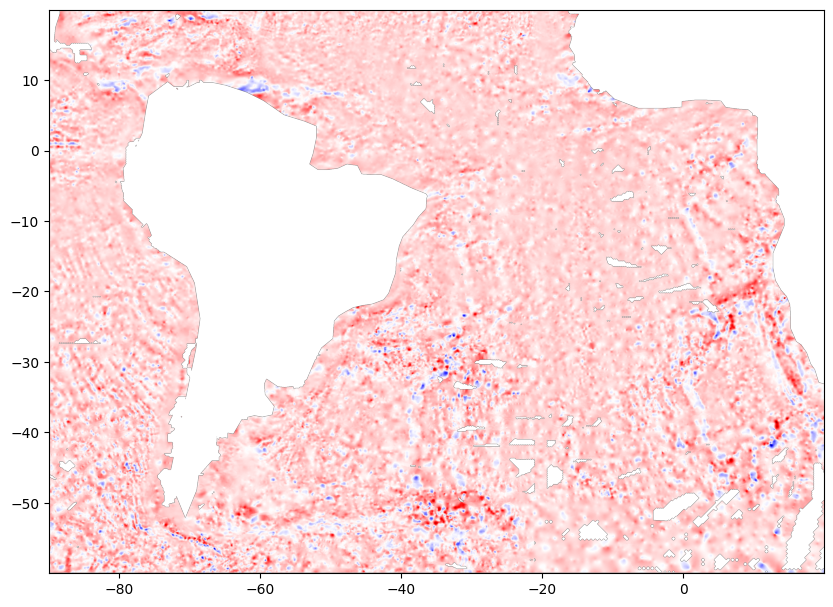

In [95]:
lon_min, lon_max = -90, 20
lat_min, lat_max = -60, 20

ix = np.where((lons >= lon_min) & (lons <= lon_max))[0]
iy = np.where((lats >= lat_min) & (lats <= lat_max))[0]

if ix.size == 0 or iy.size == 0:
  print(f"ix.size: {ix.size}, iy.size: {iy.size}")
  raise ValueError("Recorte vazio! Verifique os limites.")

data_win = data[np.ix_(iy, ix)]
lons_win = lons[ix]
lats_win = lats[iy]

fig, ax = plt.subplots(figsize=(10, 12))
im = ax.imshow(data_win,
               extent=[lons_win.min(), lons_win.max(), lats_win.min(), lats_win.max()],
               #origin='upper',
               cmap='seismic')

ax.set_title("EMAG2 win")
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
plt.colorbar(im, ax=ax, label="(nT)")

In [105]:
# FFT e filtragem espectral
ny, nx = data_win.shape
x_freq = np.fft.fftfreq(nx, d=dx)
y_freq = np.fft.fftfreq(ny, d=dy)
Xf, Yf = np.meshgrid(x_freq, y_freq)
freq_radius = np.sqrt(Xf**2 + Yf**2)
wavelength_km = 1 / (freq_radius + 1e-12) * 111  # graus → km

fft_data = fft2(np.nan_to_num(data_win, nan=0.0))
fft_data_shifted = fftshift(fft_data)

long_wave = wavelength_km > 300
short_wave = wavelength_km <= 300

long_filtered = np.real(ifft2(np.fft.ifftshift(fft_data_shifted * long_wave)))
short_filtered = np.real(ifft2(np.fft.ifftshift(fft_data_shifted * short_wave)))

## 🧮

Simplified factor for conversion. Better to convert each cell in the future.

In [106]:
factor = 111 # 1 degree ≈ 111 km

ny, nx = data_win.shape
x_freq = np.fft.fftfreq(nx, d=dx)     # resolução horizontal (longitude)
y_freq = np.fft.fftfreq(ny, d=abs(dy))     # resolução vertical (latitude)
Xf, Yf = np.meshgrid(x_freq, y_freq)
freq_radius = np.sqrt(Xf**2 + Yf**2)
wavelength_km = 1 / (freq_radius + 1e-12) * factor   # graus → km

In [108]:
print("data_win.shape =", data_win.shape)
print("x_freq.shape =", x_freq.shape)
print("y_freq.shape =", y_freq.shape)
print("Xf.shape =", Xf.shape)
print("Yf.shape =", Yf.shape)

data_win.shape = (2400, 3300)
x_freq.shape = (3300,)
y_freq.shape = (2400,)
Xf.shape = (2400, 3300)
Yf.shape = (2400, 3300)


## ✂️ Frequency intervals

In [102]:
# Substituir NaNs por zero antes da FFT
data_win = np.nan_to_num(data_win, nan=0.0)

In [109]:
ny, nx = data_win.shape
x_freq = np.fft.fftfreq(nx, d=dx)
y_freq = np.fft.fftfreq(ny, d=dy)
Xf, Yf = np.meshgrid(x_freq, y_freq)
freq_radius = np.sqrt(Xf**2 + Yf**2)
wavelength_km = 1 / (freq_radius + 1e-12) * 111  # graus → km

# Aplicar a FFT somente ao dado recortado
fft_data = fft2(np.nan_to_num(data_win, nan=0.0))
fft_data_shifted = fftshift(fft_data)

# Máscaras compatíveis com o shape da janela
long_wavelength = wavelength_km > 300
short_wavelength = wavelength_km <= 300

# Aplicar as máscaras corretamente
long_filtered = np.real(ifft2(np.fft.ifftshift(fft_data_shifted * long_wavelength)))
short_filtered = np.real(ifft2(np.fft.ifftshift(fft_data_shifted * short_wavelength)))


In [111]:
fft_data = fft2(data_win)
fft_data_shifted = fftshift(fft_data)

long_wavelength = wavelength_km > 300
short_wavelength = wavelength_km <= 300

long_filtered = np.real(ifft2(np.fft.ifftshift(fft_data_shifted * long_wavelength)))
short_filtered = np.real(ifft2(np.fft.ifftshift(fft_data_shifted * short_wavelength)))

In [112]:
def diagnostico(name, array):
    print(f"Diagnóstico de: {name}")
    print("  Tem NaN? ", np.isnan(array).any())
    print("  Tem inf? ", np.isinf(array).any())
    print("  Valor mínimo:", np.nanmin(array))
    print("  Valor máximo:", np.nanmax(array))
    print("  Valor médio:", np.nanmean(array))
    print("  Mediana:", np.nanmedian(array))
    print("  % valores = 0:", np.sum(array==0)/array.size*100, "%\n")

# Substituir NaNs e Inf por 0 se necessário
#long_filtered = np.nan_to_num(long_filtered, nan=0.0, posinf=0.0, neginf=0.0)
#short_filtered = np.nan_to_num(short_filtered, nan=0.0, posinf=0.0, neginf=0.0)

diagnostico("Original", data)
diagnostico("Longo (>300km)", long_filtered)
diagnostico("Curto (<300km)", short_filtered)

Diagnóstico de: Original
  Tem NaN?  True
  Tem inf?  False
  Valor mínimo: -1911.4905
  Valor máximo: 3539.808
  Valor médio: -0.1971279
  Mediana: -1.1729226
  % valores = 0: 0.0 %

Diagnóstico de: Longo (>300km)
  Tem NaN?  False
  Tem inf?  False
  Valor mínimo: -1.1268125
  Valor máximo: 1.126831
  Valor médio: -7.2248056e-13
  Mediana: -1.6589183e-07
  % valores = 0: 1.2626262626262626e-05 %

Diagnóstico de: Curto (<300km)
  Tem NaN?  False
  Tem inf?  False
  Valor mínimo: -886.4144
  Valor máximo: 753.13367
  Valor médio: 0.13367198
  Mediana: -0.00012934208
  % valores = 0: 0.0010606060606060605 %



In [113]:
def safe_imshow(ax, data, title, cmap='seismic', percent_clip=0.01):
    """Map show avoiding overflow by using percentil values (vmin and vmax)"""
    data_no_nan = np.nan_to_num(data, nan=0.0, posinf=0.0, neginf=0.0)
    flat = data_no_nan.flatten()
    flat = flat[~np.isnan(flat)]

    # Determina intervalo robusto ignorando outliers extremos
    vmin = np.percentile(flat, percent_clip*100)
    vmax = np.percentile(flat, (1 - percent_clip)*100)

    im = ax.imshow(data, cmap=cmap, vmin=vmin, vmax=vmax)
    ax.set_title(title)
    ax.axis('off')
    return im

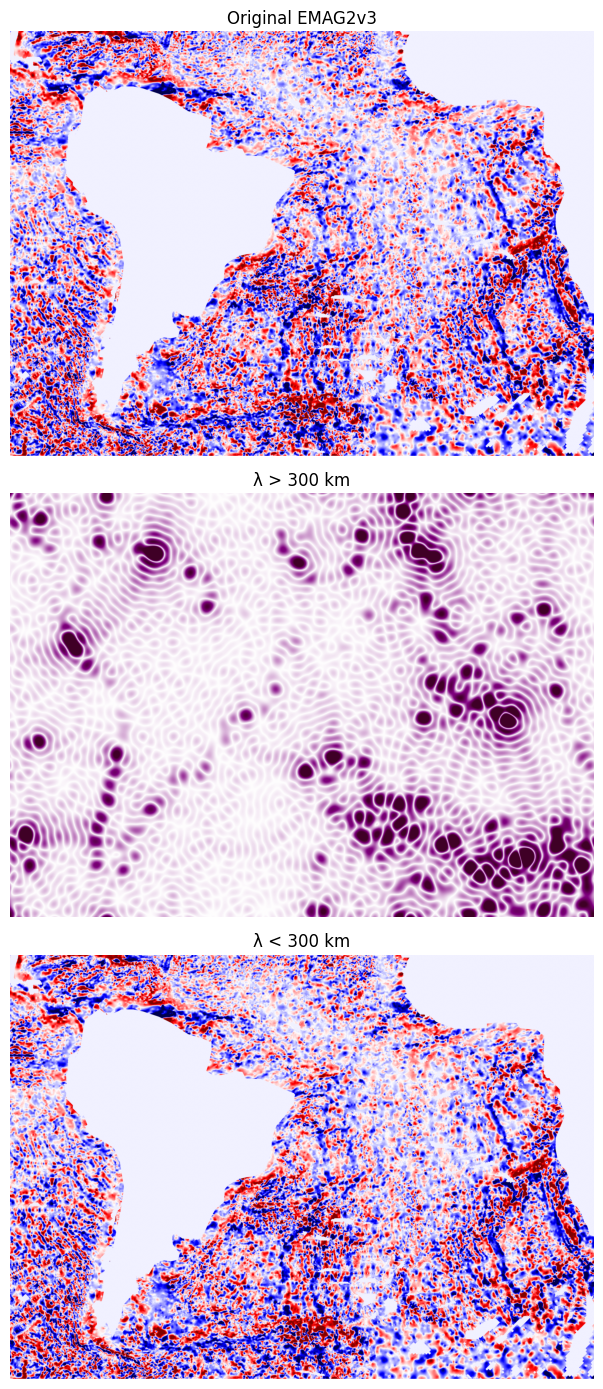

In [115]:
fig, axs = plt.subplots(3, 1, figsize=(10, 14))

safe_imshow(axs[0], data_win, 'Original EMAG2v3')
safe_imshow(axs[1], long_filtered, 'λ > 300 km')
safe_imshow(axs[2], short_filtered, 'λ < 300 km')

plt.tight_layout()
plt.show()